In [6]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import sklearn.metrics

In [7]:
# make plots look pretty
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ignore unnecesary warnings
import warnings
warnings.filterwarnings('ignore')

The sarimax model can be defined by:

$\displaystyle y_t = SARIMA(p,d,q)(P,D,Q)_m + \sum_{i=1}^{n}\beta_iX_{t}^{i}$

## forcasting USA real GDP

We'll use a macroeconomics dataset that already comes in statsmodel.

In [8]:
# load the US macroeconomics dataset.
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


We will only use 
- `realgdp`: real gross domestic product (our target variable)
- `realcons`: real personal consumption expenditure
- `realinv`: real gross private domestic investment
- `realgovt`: real federal consumption expenditure and invesment
- `realdpi`: real private disposable income
- `cpi`: consumer price index for the end of the quarter

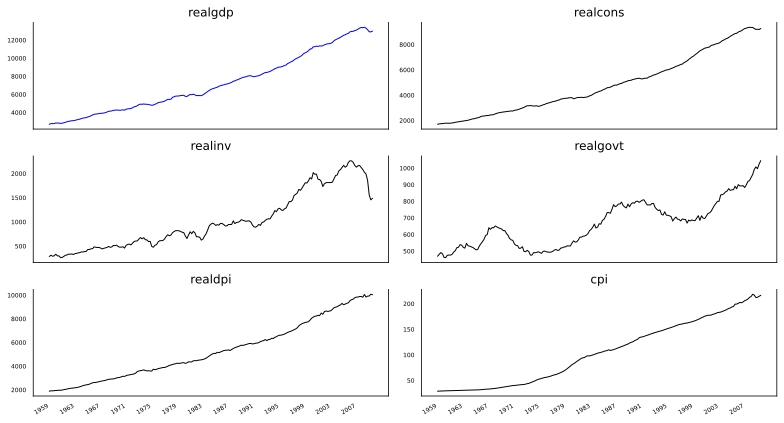

In [24]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (11, 6))

color = 'b'
for i, ax in enumerate(axs.flatten()[:6]):
    # :6 since we only want the first six
    
    # i + 2 since we want to skip year and quarter cols
    data = macro_econ_data[macro_econ_data.columns[i + 2]]
    
    ax.plot(data, color = color, linewidth = 1)
    color = 'k'
    ax.set_title(macro_econ_data.columns[i + 2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.setp(axs, xticks = np.arange(0, 208, 16), xticklabels=np.arange(1959, 2010, 4))

fig.autofmt_xdate()    
plt.tight_layout()